In [10]:
import comet_ml
import torchvision

from config import API_KEY

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4090'

In [12]:
from datasets import load_dataset

cache_dir = "upscaling/"
dataset_256_path = "upscaling/dataset_256"
dataset_512_path = "upscaling/dataset_512"
BATCH_SIZE = 14

dataset = load_dataset("huggan/wikiart", cache_dir=cache_dir, split="train").with_format('torch')

In [13]:
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

transform_256 = transforms.Compose([
    transforms.Resize((256, 256)),
])

transform_512 = transforms.Compose([
    transforms.Resize((512, 512)),
])

def preprocess_256(batch):
    batch['image'] = [transform_256(image) for image in batch['image']]
    return batch

def preprocess_512(batch):
    batch['image'] = [transform_512(image) for image in batch['image']]
    return batch

if not os.path.exists(dataset_256_path):
    dataset_256 = dataset.map(preprocess_256, batched=True, batch_size=BATCH_SIZE)
    dataset_256.save_to_disk(dataset_256_path)

if not os.path.exists(dataset_512_path):
    dataset_512 = dataset.map(preprocess_512, batched=True, batch_size=BATCH_SIZE)
    dataset_512.save_to_disk(dataset_512_path)

torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 512, 512])


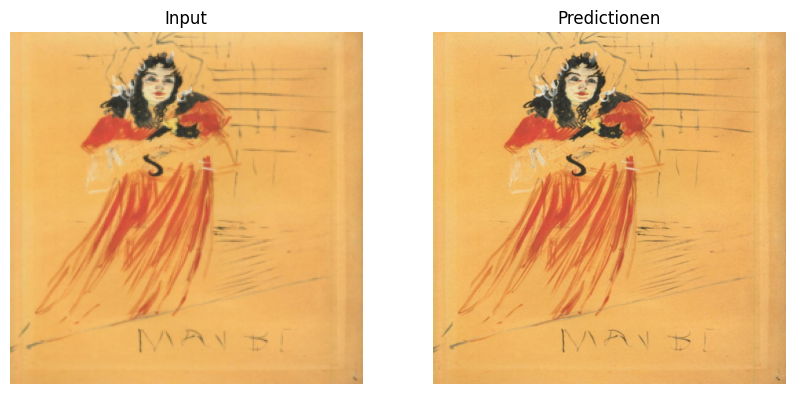

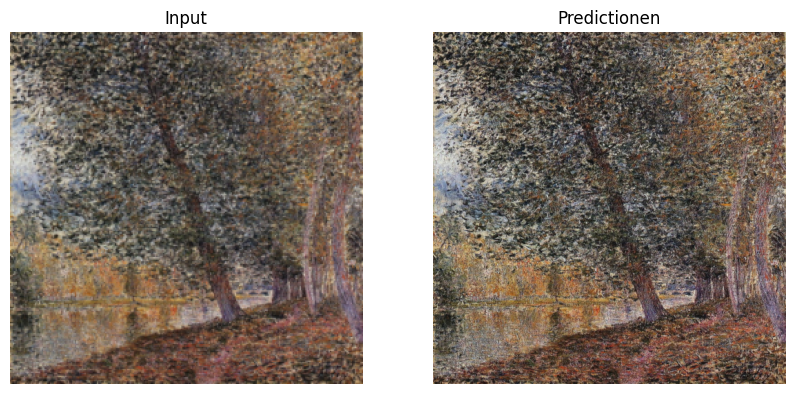

In [14]:
from datasets import load_from_disk, DatasetDict

if os.path.exists(dataset_256_path) and os.path.exists(dataset_512_path):
    dataset_256 = load_from_disk(dataset_256_path)
    dataset_512 = load_from_disk(dataset_512_path)

    train_test_split = dataset_256.train_test_split(test_size=0.05, seed=254)
    train_dataset = train_test_split['train']
    test_dataset = train_test_split['test']

    dataset_256 = {
        'train': train_dataset,
        'test': test_dataset
    }
    dataset_256 = DatasetDict(dataset_256)

    train_test_split = dataset_512.train_test_split(test_size=0.05, seed=254)
    train_dataset = train_test_split['train']
    test_dataset = train_test_split['test']

    dataset_512 = {
        'train': train_dataset,
        'test': test_dataset
    }
    dataset_512 = DatasetDict(dataset_512)

    train_loader_256 = DataLoader(dataset_256['train'], batch_size=BATCH_SIZE, shuffle=False)
    train_loader_512 = DataLoader(dataset_512['train'], batch_size=BATCH_SIZE, shuffle=False)

    test_loader_256 = DataLoader(dataset_256['test'], batch_size=BATCH_SIZE, shuffle=False)
    test_loader_512 = DataLoader(dataset_512['test'], batch_size=BATCH_SIZE , shuffle=False)


    train_iter_512 = iter(train_loader_512)

    for idx, batch_256 in enumerate(train_loader_256):
        print(batch_256['image'].shape)
        batch_512 = next(train_iter_512)
        print(batch_512['image'].shape)
        images_256 = batch_256['image'].permute(0, 2, 3, 1)
        images_512 = batch_512['image'].permute(0, 2, 3, 1)
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(images_256[0])
        axes[0].axis('off')
        axes[0].set_title("Input")

        axes[1].imshow(images_512[0])
        axes[1].axis('off')
        axes[1].set_title("Predictionen")
        if idx == 1:
            break



In [17]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


def log_images_to_comet(images, experiment, idx, epoch, tr_step):
    grid = make_grid(images, nrow=8, padding=2)
    
    np_grid = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(15, 15))
    plt.imshow(np.clip(np_grid, 0, 1))
    plt.axis("off")
    experiment.log_figure(figure_name=f'{tr_step}:{idx}', figure=plt, step=epoch)
    plt.close()

In [18]:
from tqdm import tqdm

from comet_ml.integration.pytorch import log_model

from torchinfo import summary

from models import UNetUpscaler, CombinedLoss

if __name__ == '__main__':

    model = UNetUpscaler()
    model.apply(init_weights)
    model.cuda()

    loss_fn = CombinedLoss()

    comet_experiment = comet_ml.Experiment(api_key=API_KEY, project_name='UN_upscale')

    summ = summary(model, (1,3,256,256), device='cuda',depth=5)
    comet_experiment.set_model_graph(f'{model.__repr__()}\n{summ}')

    num_epochs = 40

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

    comet_experiment.log_parameter('num_epochs', num_epochs)

    for epoch in range(num_epochs):
        comet_experiment.set_epoch(epoch)
        model.train()

        with comet_experiment.train() as train:
            train_iter_512 = iter(train_loader_512)
            for idx, batch_256 in enumerate(tqdm(train_loader_256, desc=f'TRAIN_{epoch}', leave=True)):
                comet_experiment.set_step(idx + epoch * len(train_loader_256))

                images = batch_256['image'] / 255.0
                labels = next(train_iter_512)
                labels = labels['image'] / 255.0

                optimizer.zero_grad()
                images = images.cuda()
                labels = labels.cuda()

                predictions = model(images)

                l1, per, style = loss_fn(predictions, labels)
                loss = l1 + per + style

                loss.backward()
                optimizer.step()


                comet_experiment.log_metric('l1_loss', l1)
                comet_experiment.log_metric('per_loss', per)
                comet_experiment.log_metric('style_loss', style)

        model.eval()
        with comet_experiment.test() as test, torch.no_grad() as nograd:
            test_iter_512 = iter(test_loader_512)
            for idx, batch_256 in enumerate(tqdm(test_loader_256, desc=f'TEST_{epoch}', leave=True)):
                comet_experiment.set_step(idx + epoch * len(test_loader_256))

                images = batch_256['image'] / 255.0
                labels = next(test_iter_512)
                labels = labels['image'] / 255.0

                images = images.cuda()
                labels = labels.cuda()
                predictions = model(images)
                l1, per, style = loss_fn(predictions, labels)
                loss = l1 + per + style


                comet_experiment.log_metric('l1_loss', l1)
                comet_experiment.log_metric('per_loss', per)
                comet_experiment.log_metric('style_loss', style)

                if idx < 2:
                    concatenated = torch.cat([labels, predictions], dim=3).cpu()
                    log_images_to_comet(concatenated, comet_experiment, idx, epoch, 'TEST')


        
        torch.save(model.state_dict(), f"models/model_upscale_{epoch}.pth")

    log_model(comet_experiment, model, model_name="UNetUpscale")
    comet_experiment.end()

e:\repos\inpainting-art\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\repos\inpainting-art\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : smiling_amberjack_4438
CO

KeyboardInterrupt: 